In [1]:
# Please execute/shift-return this cell everytime you run the notebook.  Don't edit it. 
%load_ext autoreload
%autoreload 2
from notebook import * 

/nfshome/htseng/courses/CSE142/demo/amdahlslaw/notebook.py:229: SyntaxWarning: invalid escape sequence '\s'
  show = (f"[\s\*]{show}\s*\(", "^\}")
/nfshome/htseng/courses/CSE142/demo/amdahlslaw/notebook.py:229: SyntaxWarning: invalid escape sequence '\s'
  show = (f"[\s\*]{show}\s*\(", "^\}")
/nfshome/htseng/courses/CSE142/demo/amdahlslaw/notebook.py:229: SyntaxWarning: invalid escape sequence '\}'
  show = (f"[\s\*]{show}\s*\(", "^\}")


# Amdahl's Law

## The starting example -- sorting

In [2]:
render_code("./gpusort/main.cu", show="main")

// ./gpusort/main.cu:516-682 (167 lines)
int main( int argc, char** argv)
{ 

  // Create timers for each sort
    struct timeval time_start, time_end, program_start, program_end;
    double input_time=0;
    gettimeofday(&program_start, NULL);	

    sdkCreateTimer(&uploadTimer);
    sdkCreateTimer(&downloadTimer);
    sdkCreateTimer(&bucketTimer);
    sdkCreateTimer(&mergeTimer);
    sdkCreateTimer(&totalTimer);
    sdkCreateTimer(&cpuTimer);
	int numElements = 0;
	int method=0;
    // Number of elements in the test bed
    	gettimeofday(&time_start, NULL);
#ifdef READING_FROM_BINARY
        numElements = atoi(argv[2]);
	if (argc == 4)
		method = atoi(argv[3]);
#else
       	if(strcmp(argv[1],"r") ==0) {
	         numElements = SIZE; 
	    }
	else {
		FILE *fp;
	    fp = fopen(argv[1],"r");
	    if(fp == NULL) {
	        cout << "Error reading file" << endl;
	        exit(EXIT_FAILURE);
	    }
	    int count = 0;
	    float c;

	    while(fscanf(fp,"%f",&c) != EOF) {
	        count++;
        }
	    fclose(fp);
	    numElements = count;
    }
#endif

	cout << "Sorting list of " << numElements << " floats\n";
	// Generate random data
	// Memory space the list of random floats will take up
	int mem_size = numElements * sizeof(float); 
	// Allocate enough for the input list
	float *cpu_idata = (float *)malloc(mem_size);
	// Allocate enough for the output list on the cpu side
	float *cpu_odata = (float *)malloc(mem_size);
	// Allocate enough memory for the output list on the gpu side
	float *gpu_odata = (float *)malloc(mem_size);

	float datamin = FLT_MAX; 
	float datamax = -FLT_MAX; 
	if(strcmp(argv[1],"r")==0) {

	for (int i = 0; i < numElements; i++) {
	// Generate random floats between 0 and 1 for the input data
		cpu_idata[i] = ((float) rand() / RAND_MAX); 
	//Compare data at index to data minimum, if less than current minimum, set that element as new minimum
		datamin = min(cpu_idata[i], datamin);
	//Same as above but for maximum
		datamax = max(cpu_idata[i], datamax);
	}
    }	else {
	FILE *fp;
#ifdef READING_FROM_BINARY
	fp = fopen(argv[1],"rb");
	fread(cpu_idata,sizeof(float),numElements,fp);
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
	
    /*	for(int i = 0; i < numElements; i++) {
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}*/

	datamin = 0.0;
	datamax = 16777215.0;
#else
	fp = fopen(argv[1],"r");
	for(int i = 0; i < numElements; i++) {
	fscanf(fp,"%f",&cpu_idata[i]);
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
    	gettimeofday(&time_start, NULL);	
#endif
	}
#ifndef CPU
	cout << "Sorting on GPU..." << flush; 
	// GPU Sort
	if(method == 0)
	for (int i = 0; i < TEST; i++) 
        MergeSort(cpu_idata, numElements, THREADS_PER_BLOCK, numElements/THREADS_PER_BLOCK);
//		gpu_quicksort(cpu_idata, gpu_odata, numElements);		
	else {
	// Using bitonic sort
	for (int i = 0; i < TEST; i++) 
		bitonic_sort(cpu_idata, gpu_odata, numElements);		
	}
#endif

#if defined(VERIFY) || (defined CPU)
	cout << "Sorting on CPU..." << flush; 
	// Start_CPU_Sort
	sdkStartTimer(&cpuTimer); 
	memcpy(cpu_odata, cpu_idata, mem_size);
    qsort(cpu_odata, numElements, sizeof(float), compare);
	sdkStopTimer(&cpuTimer); 
    // End_CPU_Sort 
	cout << "done.\n";
	#ifdef VERIFY
    cout << "Checking result..." << flush; 
	// Result checking
	int count = 0; 
	for(int i = 0; i < numElements; i++)
		if(fabs(cpu_odata[i] - gpu_odata[i])> 0.0002)
		{
			printf("Sort missmatch on element %d: \n", i); 
			printf("CPU = %f : GPU = %f\n", cpu_odata[i], gpu_odata[i]); 
			count++; 
			break; 
		}

## Where is the most time critical part of my program?

In [3]:
! cd gpusort; make clean; make
! perf record gpusort/hybridsort_cpu ~/courses/CSE142/demo/300000000.bin 134217728 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g    -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g    -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
Sorting list of 134217728 floats
FileInput 0.146467 seconds
Sorting on CPU...done.
Total CPU execution time: 15.480531 seconds


In [4]:
! perf report --stdio > perf.out

Kernel address maps (/proc/{kallsyms,modules}) were restricted.

Check /proc/sys/kernel/kptr_restrict before running 'perf record'.

As no suitable kallsyms nor vmlinux was found, kernel samples
can't be resolved.

Samples in kernel modules can't be resolved as well.



In [5]:
! head -20 perf.out

# To display the perf.data header info, please use --header/--header-only options.
#
#
# Total Lost Samples: 0
#
# Samples: 44  of event 'cpu_atom/cycles/P'
# Event count (approx.): 38723711
#
# Overhead  Command         Shared Object         Symbol                   
# ........  ..............  ....................  .........................
#
    35.03%  hybridsort_cpu  [unknown]             [k] 0xffffffffa2299a9e
    17.01%  hybridsort_cpu  [unknown]             [k] 0xffffffffa2c1ae37
     2.63%  hybridsort_cpu  [unknown]             [k] 0xffffffffa1ef3eb1
     2.63%  hybridsort_cpu  [unknown]             [k] 0xffffffffa1e50a03
     2.62%  hybridsort_cpu  [unknown]             [k] 0xffffffffa2e01248
     2.62%  hybridsort_cpu  [unknown]             [k] 0xffffffffa1e51e83
     2.62%  hybridsort_cpu  [unknown]             [k] 0xffffffffa1e81907
     2.62%  hybridsort_cpu  [unknown]             [k] 0xffffffffa2caf23e
     2.62%  hybridsort_cpu  [unknown]             [k] 0xffffffffa1bea

In [6]:
! cd gpusort; make clean; make
! echo "File on H.D.D.; Sorting on CPU"
! cd ./gpusort; echo "ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host" > sort.csv; source ./run_CPU 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g    -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g    -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on CPU
Sorting list of 134217728 floats
FileInput 0.147963 seconds
Sorting on CPU...done.
Total CPU execution time: 15.396415 seconds


In [7]:
display_df_mono(render_csv("./gpusort/sort.csv", columns=["ET","FileInput","CPU_Kernel"]))

,index,ET,FileInput,CPU_Kernel
0,0,15.544419,0.147963,15.396415


In [8]:
! lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          39 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   24
  On-line CPU(s) list:    0-23
Vendor ID:                GenuineIntel
  Model name:             13th Gen Intel(R) Core(TM) i7-13700F
    CPU family:           6
    Model:                183
    Thread(s) per core:   2
    Core(s) per socket:   16
    Socket(s):            1
    Stepping:             1
    CPU(s) scaling MHz:   29%
    CPU max MHz:          5200.0000
    CPU min MHz:          800.0000
    BogoMIPS:             4224.00
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 s
                          s ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc 
                          art arch_perfmon pebs bts rep_good nopl xtopology nons
                          top_tsc 

### Use gprof to figure out the timing breakdown

In [9]:
! cd gpusort; make clean; make EXTRA_FLAGS=-pg 
! cd ./gpusort; source ./run_CPU

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g  -pg  -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g  -pg  -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
Sorting list of 134217728 floats
FileInput 0.143653 seconds
Sorting on CPU...done.
Total CPU execution time: 26.152971 seconds
26.296660, 0.143653, 26.152971, 0.000000, 0.000000, 0.000000


In [10]:
! cd gpusort; gprof ./hybridsort_cpu ./gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
100.00      1.85     1.85                             compare(void const*, void const*)
  0.00      1.85     0.00        6     0.00     0.00  __cudaUnregisterBinaryUtil()
  0.00      1.85     0.00        6     0.00     0.00  StopWatchLinux::~StopWatchLinux()
  0.00      1.85     0.00        5     0.00     0.00  StopWatchLinux::getTime()
  0.00      1.85     0.00        1     0.00     0.00  StopWatchLinux::stop()
  0.00      1.85     0.00        1     0.00     0.00  StopWatchLinux::start()

 %         the percentage of the total running time of the
time       program used by this function.

cumulative a running sum of the number of seconds accounted
 seconds   for by this function and those listed above it.

 self      the number of seconds accounted for by this
seconds    function alone.  This is the major sort 

## Amdahl's Law -- optimizating is a moving target

In [11]:
render_code("./gpusort/main.cu", lang="c++", show="bitonic_sort")

// ./gpusort/main.cu:63-92 (30 lines)
void bitonic_sort(float *values, float *out_values, int num_of_elements)
{
  float *dev_values;
  size_t size = num_of_elements * sizeof(float);
  int BLOCKS = num_of_elements/THREADS_PER_BLOCK; 

  cudaMalloc((void**) &dev_values, size);
  sdkStartTimer(&uploadTimer);
  cudaMemcpy(dev_values, values, size, cudaMemcpyHostToDevice);
  sdkStopTimer(&uploadTimer); 
  dim3 blocks(BLOCKS,1);    /* Number of blocks   */
  dim3 threads(THREADS_PER_BLOCK,1);  /* Number of threads  */

  sdkStartTimer(&totalTimer); 
  int j, k;
  /* Major step */
  for (k = 2; k <= num_of_elements; k <<= 1) {
    /* Minor step */
    for (j=k>>1; j>0; j=j>>1) {
      bitonic_sort_step<<<blocks, threads>>>(dev_values, j, k);
    }
  }
		cudaThreadSynchronize(); 
  sdkStopTimer(&totalTimer); 
  sdkStartTimer(&downloadTimer);
  cudaMemcpy((void *)out_values, (void *)dev_values,  num_of_elements*sizeof(float), cudaMemcpyDeviceToHost);
//		checkCudaErrors(cudaMemcpy((void *)out_values, (void *)dev_values, num_of_elements*sizeof(float), cudaMemcpyDeviceToHost));
  sdkStopTimer(&downloadTimer); 
  cudaFree(dev_values);
}

In [12]:
! nvidia-smi -a


==============NVSMI LOG==============

Timestamp                                 : Wed Jul 30 19:28:10 2025
Driver Version                            : 555.42.06
CUDA Version                              : 12.5

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA GeForce RTX 4070 Ti SUPER
    Product Brand                         : GeForce
    Product Architecture                  : Ada Lovelace
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
  

In [13]:
! cd gpusort; make clean; make
# ! ssh htseng@azelf "source ./courses/CS203/demo/amdahlslaw/gpusort/run_CPU"
! echo "File on H.D.D.; Sorting on GPU"
! cd gpusort; source ./run 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g    -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -g    -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 0.149242 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.918221 seconds
    - Upload		: 0.036963 seconds
    - Download		: 0.147330 seconds


In [14]:
display_df_mono(render_csv("./gpusort/sort.csv"))

,index,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,0,15.544419,0.147963,15.396415,0.000000,0.000000,0.000000
1,1,1.341677,0.149242,0.000000,0.918221,0.036963,0.147330


In [15]:
! echo "File on S.S.D.; Sorting on GPU"
! cd gpusort; source ./run_SSD 2>> sort.csv

File on S.S.D.; Sorting on GPU
Sorting list of 134217728 floats


In [16]:
display_df_mono(render_csv("./gpusort/sort.csv"))

,index,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,0,15.544419,0.147963,15.396415,0.000000,0.000000,0.000000
1,1,1.341677,0.149242,0.000000,0.918221,0.036963,0.147330
2,2,./run_SSD: line 2: 497177 Segmentation fault (core dumped) ./hybridsort /tmp/300000000.bin 134217728 1,nan,nan,nan,nan,nan


## Amdahl's Law on parallel programming

In [17]:
! cd vmul; make clean; make
! echo "THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST" > ./vmul/vmul.csv
! echo "CPU based vul"
! time ./vmul/vmul 33554432 1 0 30 2>> ./vmul/vmul.csv
! echo "GPU based vul"
### i stands for "How many iterations each thread performs 
### -- the larger the number, the fewer the parallelism
! for i in 1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192; do time ./vmul/vmul 33554432 $i 1 30 2>> ./vmul/vmul.csv ; done

rm -f vmul *.o
gcc -O3 vmul.c -c
gcc -O3 vmul_cpu.c -c
/usr/local/cuda/bin/nvcc -O3 -w vmul_cuda.cu -c
gcc -O3 *.o -lcuda -lcudart -L/usr/local/cuda/lib64 -o vmul
CPU based vul
Using CPU
kernel: 0.296310 seconds

real	0m1.094s
user	0m0.990s
sys	0m0.099s
GPU based vul
memcpy (to device): 0.129626 seconds
Using GPU
kernel: 0.020810 seconds
memcpy (to host): 0.018739 seconds

real	0m0.990s
user	0m0.757s
sys	0m0.210s
memcpy (to device): 0.124655 seconds
Using GPU
kernel: 0.013255 seconds
memcpy (to host): 0.019508 seconds

real	0m0.976s
user	0m0.742s
sys	0m0.229s
memcpy (to device): 0.124188 seconds
Using GPU
kernel: 0.025196 seconds
memcpy (to host): 0.018646 seconds

real	0m0.985s
user	0m0.742s
sys	0m0.238s
memcpy (to device): 0.124371 seconds
Using GPU
kernel: 0.032318 seconds
memcpy (to host): 0.018967 seconds

real	0m0.995s
user	0m0.754s
sys	0m0.235s
memcpy (to device): 0.126492 seconds
Using GPU
kernel: 0.054479 seconds
memcpy (to host): 0.018818 seconds

real	0m1.019s
user	0m0.794s


,index,THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST,TOTAL
0,0,0.000000,0.296310,0.000000,0.000000,0.000000,0.296310
14,14,4.000000,0.000000,0.122808,0.286117,0.018869,0.427794
13,13,8.000000,0.000000,0.123117,0.143779,0.018445,0.285341
12,12,16.000000,0.000000,0.124179,0.075351,0.018693,0.218223
11,11,32.000000,0.000000,0.127619,0.060392,0.019024,0.207035
10,10,64.000000,0.000000,0.123576,0.057719,0.019060,0.200355
9,9,128.000000,0.000000,0.122576,0.056488,0.018530,0.197594
8,8,256.000000,0.000000,0.120568,0.057154,0.018549,0.196271
7,7,512.000000,0.000000,0.124448,0.054751,0.019009,0.198208
6,6,1024.000000,0.000000,0.125576,0.055440,0.018867,0.199883


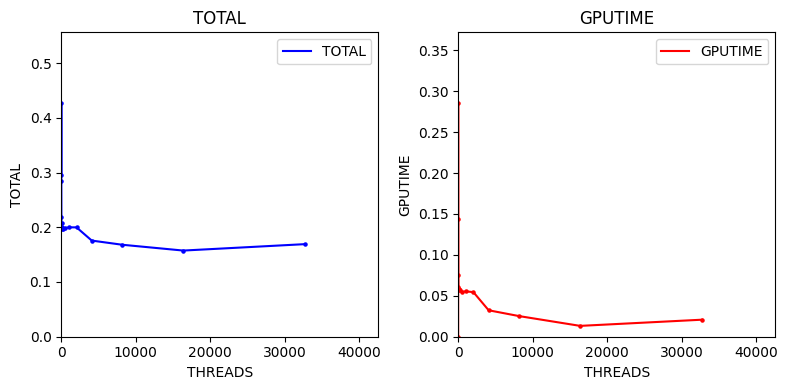

In [18]:
df = render_csv("./vmul/vmul.csv")
df["TOTAL"] = df["CPUTIME"] + df["HOST2GPU"] + df["GPUTIME"] + df["GPU2HOST"]
df = df.sort_values(by=["THREADS"], ascending=True)
display_df_mono(df)
plotPE(df=df, lines=True, what=[ ('THREADS', "TOTAL"), ('THREADS', "GPUTIME")], columns=2)

# Choose the "right" metrics

## Throughput and Latency

### SSD v.s. HDD

You may use to hdparm (need root permission to execute). The /dev/sda on this machine is an SATA SSD that has around 450-500MB/sec bandwidth. The /dev/md0 is a RAID contains two H.D.Ds in RAID-0 configuration that also achieves 450-500MB/sec bandwidth. Let's examine the bandwidth using the following command.

In [19]:
from IPython.display import IFrame
IFrame("https://hub.escalab.org:8000/user/htseng/terminals/1", width="100%", height="400")

Now, let's revisit the optimized gpusort on this machine with different array size...

In [20]:
! echo "Configuration,Size,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host" > sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 512 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 512 2>> ../sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 32768 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 32768 2>> ../sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 262144 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 262144 2>> ../sort_small.csv
display_df_mono((render_csv("sort_small.csv")))

File on H.D.D
Sorting list of 512 floats
FileInput 0.000124 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.000269 seconds
    - Upload		: 0.000011 seconds
    - Download		: 0.000008 seconds
Sorting list of 512 floats
FileInput 0.000059 seconds
Sorting on CPU...done.
Total CPU execution time: 0.000022 seconds
File on S.S.D
Sorting list of 512 floats
Sorting list of 512 floats
File on H.D.D
Sorting list of 32768 floats
FileInput 0.000121 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.000387 seconds
    - Upload		: 0.000020 seconds
    - Download		: 0.000055 seconds
Sorting list of 32768 floats
FileInput 0.000131 seconds
Sorting on CPU...done.
Total CPU execution time: 0.003225 seconds
File on S.S.D
Sorting list of 32768 floats
Sorting list of 32768 floats
File on H.D.D
Sorting list of 262144 floats
FileInput 0.000514 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.000736 seconds
    - Upload		: 0.000076

,index,Configuration,Size,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,0,HDD+GPU,512,0.085940,0.000124,0.000000,0.000269,0.000011,0.000008
1,1,HDD+CPU,512,0.000091,0.000059,0.000022,0.000000,0.000000,0.000000
2,2,SSD+GPU,512,./run_small_SSD: line 3: 497313 Segmentation fault (core dumped) ./hybridsort /tmp/300000000.bin $1 1,nan,nan,nan,nan,nan
3,3,SSD+CPU,512,./run_small_SSD: line 6: 497315 Segmentation fault (core dumped) ./hybridsort_cpu /tmp/300000000.bin $1 1,nan,nan,nan,nan,nan
4,4,HDD+GPU,32768,0.087609,0.000121,0.000000,0.000387,0.000020,0.000055
5,5,HDD+CPU,32768,0.003371,0.000131,0.003225,0.000000,0.000000,0.000000
6,6,SSD+GPU,32768,./run_small_SSD: line 3: 497326 Segmentation fault (core dumped) ./hybridsort /tmp/300000000.bin $1 1,nan,nan,nan,nan,nan
7,7,SSD+CPU,32768,./run_small_SSD: line 6: 497328 Segmentation fault (core dumped) ./hybridsort_cpu /tmp/300000000.bin $1 1,nan,nan,nan,nan,nan
8,8,HDD+GPU,262144,0.095278,0.000514,0.000000,0.000736,0.000076,0.000374
9,9,HDD+CPU,262144,0.021310,0.000407,0.020886,0.000000,0.000000,0.000000


What can we observe here?

## FLOPs

In [21]:
! cd metrics; make; echo "size,GLOPS,GPU_time" > flops.csv

make: Nothing to be done for 'all'.


In [22]:
! cd ./metrics; time ./cpumm 2048 512

Data type size: 4

Time: 4409.180 ms

Throughput: 3.90 GFLOPS


real	0m4.527s
user	0m4.489s
sys	0m0.016s


In [23]:
! cd ./metrics; time ./cudamm 2048 1 2>> flops.csv 

Data Type Size: 4
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 13.353536 ms.


Throughput: 1286.54 GFLOPS


real	0m0.283s
user	0m0.095s
sys	0m0.134s


In [24]:
! cd ./metrics; time ./cudamm 4096 1 2>> flops.csv 

Data Type Size: 4
Time elapsed on matrix multiplication of 4096x4096 . 4096x4096 on GPU: 107.803360 ms.


Throughput: 1274.90 GFLOPS


real	0m0.602s
user	0m0.431s
sys	0m0.166s


In [25]:
! cd metrics; time ./cudamm 8192 1 2>> flops.csv 

Data Type Size: 4
Time elapsed on matrix multiplication of 8192x8192 . 8192x8192 on GPU: 1237.671509 ms.


Throughput: 888.37 GFLOPS


real	0m2.802s
user	0m2.486s
sys	0m0.312s


In [26]:
! ssh htseng@lapras "time /nfshome/htseng/courses/CSE142/demo/amdahlslaw/metrics/cudamm 8192 1 2>> /nfshome/htseng/courses/CSE142/demo/amdahlslaw/metrics/flops.csv "

Data Type Size: 4
Time elapsed on matrix multiplication of 8192x8192 . 8192x8192 on GPU: 349.447388 ms.


Throughput: 3146.43 GFLOPS


real	0m1.904s
user	0m1.519s
sys	0m0.373s


In [27]:
FLOPS_Ratio = 781.863586/348.333954
print(FLOPS_Ratio)

2.2445804579819977


In [28]:
Speedup = 2.610/1.991
print(Speedup)

1.3108990457056755


In [29]:
! cd metrics; time ./cudamm_double 2048 1

Data Type Size: 8
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 40.757984 ms.


Throughput: 421.51 GFLOPS

2048x2048x2048, 40.757984, 421.51

real	0m0.311s
user	0m0.142s
sys	0m0.143s


In [30]:
! cd metrics;  ./cudamm_double 2048 0

Data Type Size: 8
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 39.684223 ms.


Throughput: 432.91 GFLOPS

2048x2048x2048, 39.684223, 432.91


In [31]:
! cd metrics; time ./cpumm_double 2048 512

Data type size: 8

Time: 10047.859 ms

Throughput: 1.71 GFLOPS


real	0m10.156s
user	0m10.126s
sys	0m0.022s


In [32]:
! cd metrics;  time ./cudamm 2048 0

Data Type Size: 4
Time elapsed on matrix multiplication of 2048x2048 . 2048x2048 on GPU: 14.035232 ms.


Throughput: 1224.05 GFLOPS

2048x2048x2048, 14.035232, 1224.05

real	0m0.236s
user	0m0.096s
sys	0m0.137s
